# CS6140: Machine Learning
## Final Project: Predicting Pathogenicity with Machine Learning models
### Dr. Hongyang Zhang 
### Alfonso Barajas

In [13]:
# Packages 
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


# Ignore warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

Preprocessed final data we got is ClinVar variants from $2020-2023$ where $21,331$ are **P/LP** (Pathogenic/Likely Pathogenic) and $20, 702$ **B/LB** (Benign/Likely Benign) variants. Given that in the real life we have nearly $22.3$ benign variants per one pathogenic variant, we bootstrap the nearly $42k$ to obtain $400k$ variants in the dataset. 

In [3]:
url_data = "./data/finalboot.csv"
data =  pd.read_csv(url_data)

We can notice the table in the following cell. We have the following columns:
- POS: Position where the
- REF: 
- ALT: 
- GeneID:

In [4]:
data.head()

,CHROM,POS,REF,ALT,GeneID,RS,DS,Y,REVEL,SAI
0,1,1232279,A,G,126792.0,0.188,0.0,1,-2,I
1,1,1232280,T,A,126792.0,0.206,0.0,1,-2,I
2,1,1232280,T,C,126792.0,0.203,0.0,1,-2,I
3,1,1232281,G,A,126792.0,0.240,0.0,1,-2,I
4,1,1232478,C,T,126792.0,0.288,0.0,1,-2,I


In [6]:
data.shape

(496831, 10)

The real version of the data is $42k$ varaints

**Justification why data bootstrapped for Bayesian Network Framework**:We have in total nearly about $496,831$ variants, where unique data files are $42,013$ variants. There rest is just using the benign data to be bootstraped in a manner that reflects what is happening in reality. This data is to be applied for the Bayesian Network framework package in both Python and R. Primarly, we did this due to the fact that the Prior probability of Pathogenicity $P(Y=1) = \alpha$ is not the one that we have in the data but in the bootstrap according to literature review Pejaver et al. Calibration of computational tools for missense variant pathogenicity classification and ClinGen recommendations for PP3/BP4 criteria (2022)

### Models to compare:

1. Logistic Regression
2. Naive Bayes
3. Random Forest Classifier
4. Neural Network Classifier

### Models to understand interplay of lines of evidence
5. Bayesian Networks (RStudio)
6. Bayesian Networks with Latent Variables (Python and RStudio)

For this project there is a principal goal which is to see how Bayesian Networks with and without Latent Variable are compared with the rest of the machine learning models compared with different degrees of interpratibility/complexity. All models will be trained and tested accordingly with $70\%$ and $30\%$ of data. We will be using different evaluation measurments such as accuracy and Area Under the Curve scores (Reciever Operator Curve) that plays an important role comparing the specificity and sensitivty of the classification models.

### Train and Test data

Splitting data $70\%$ and $30\%$ such that we have respectively $70\%$ of pathogenic and benign variants in the train data and $30\%$ in the test data. For that we will have division of pathogenic and benign, and then splitting and then combining datasets to have final training and testing data.

We will have $332,864$ in the benign group whereas in the pathogenic group it will be close to $14,918$. The remaining will be in the test data.

In [90]:
def train_test_path(df, perc = 0.7):
    colsnames = list(df.columns)
    dfb = df[df["Y"] == 0]
    dfp = df[df["Y"] == 1]
    nb = len(dfb)
    npa = len(dfp)
    num_elements_b = int(np.round(nb * perc))
    num_elements_p = int(np.round(npa * perc))
    list_idx_train_b = np.random.choice(nb , num_elements_b, replace=False)
    list_idx_test_b = [i for i in np.array(list(range(nb))) if i not in list_idx_train_b]
    list_idx_train_p = np.random.choice(npa , num_elements_p, replace=False)
    list_idx_test_p = [i for i in np.array(list(range(npa))) if i not in list_idx_train_p]
    list_df_train = []
    list_df_test = []
    for id in list_idx_train_b:
        to_add = list(dfb.iloc[id])
        list_df_train.append(to_add)
    for id in list_idx_train_p:
        to_add = list(dfp.iloc[id])
        list_df_train.append(to_add)
    for id in list_idx_test_b:
        to_add = list(dfb.iloc[id])
        list_df_test.append(to_add)
    for id in list_idx_test_p:
        to_add = list(dfp.iloc[id])
        list_df_test.append(to_add)
    df_train = pd.DataFrame(list_df_train, columns= colsnames)
    df_test = pd.DataFrame(list_df_test, columns= colsnames)
    return df_train, df_test
    

In [91]:
df_train, df_test = train_test_path(data)

In [97]:
df_train.shape[0] == np.round(496831 * 0.7)

True

In [99]:
df_test.shape[0] == np.round(496831 * 0.3)

True

In [53]:
# df_train.to_csv('../data/datatrain.csv', index=False)
# df_test.to_csv('../data/datatest.csv', index=False)

In [6]:
df_train = pd.read_csv('../data/datatrain.csv')
df_test = pd.read_csv('../data/datatrain.csv')

In [7]:
X_train = np.array(df_train[["RS", "DS"]])
y_train = np.array(df_train[["Y"]])

In [8]:
X_test = np.array(df_test[["RS","DS"]])
y_test = np.array(df_test[["Y"]])

In [15]:
# Function to calculate Accuracy scores for Train and test data
def get_accuracies(model, x_train = X_train, y_train=y_train, x_test= X_test, y_test=y_test):
    score_train = model.score(x_train, y_train)
    score_train = score_train * 100
    score_test = model.score(x_test, y_test)
    score_test = score_test * 100
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    precision_train = precision_score(y_train, y_pred_train)
    precision_test= precision_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test  = recall_score(y_test, y_pred_test)
    f1_train     = f1_score(y_train, y_pred_train)
    f1_test      = f1_score(y_test, y_pred_test)
    print(f'Accuracy train = {score_train:.2f} , Accuracy test = {score_test:.2f}')
    print(f'Precision train = {precision_train:.2f} , Precision test = {precision_test:.2f}')
    print(f'Recall train = {recall_train:.2f} , Recall test = {recall_test:.2f}')
    print(f'F1 train = {f1_train:.2f} , F1 test = {f1_test:.2f}')
    return score_train, score_test, precision_train,precision_test,recall_train,recall_test,f1_train,f1_test

In [54]:
# Function to calculate confusion matrix
def get_confmatrix(model, x, y):
    y_pred = model.predict(x)
    conf = confusion_matrix(y, y_pred)
    conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot()
    sns.heatmap(conf, annot=True, fmt='.2%', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix')

In [17]:
def get_roc_curve(model, x, y):
    y_pred = model.predict_proba(x)[:, 1]
    fpr , tpr, _ = roc_curve(y, y_pred)
    auc = round(roc_auc_score(y, y_pred) ,4)
    return fpr, tpr, auc

In [18]:
accuracies_train = []
accuracies_test = []
precision_train = []
precision_test = []
recall_train = []
recall_test = []
f1_train = []
f1_test = []


### Logistic Regression
---

In [19]:
clr = LogisticRegression(random_state=7).fit(X_train, y_train.ravel())

In [20]:
clr.coef_

array([[9.192767  , 2.95062449]])

In [21]:
clr.intercept_

array([-8.42776078])

In [22]:
a,b,c,d,e,f,g,h = get_accuracies(clr)
accuracies_train.append(a)
accuracies_test.append(b)
precision_train.append(c)
precision_test.append(d)
recall_train.append(e)
recall_test.append(f)
f1_train.append(g)
f1_test.append(h)

Accuracy train = 96.79 , Accuracy test = 96.79
Precision train = 0.71 , Precision test = 0.71
Recall train = 0.42 , Recall test = 0.42
F1 train = 0.53 , F1 test = 0.53


We got confusion matrix for test data set

Obtaining parameters to plot ROC Curves for different models

In [23]:
fpr1, tpr1, auc1 = get_roc_curve(clr, X_test, y_test)

### Naive Bayes Classifier
---


In [25]:
clnb = GaussianNB()
clnb.fit(X_train, y_train.ravel())

GaussianNB()

In [26]:
a,b,c,d,e,f,g,h = get_accuracies(clnb)
accuracies_train.append(a)
accuracies_test.append(b)
precision_train.append(c)
precision_test.append(d)
recall_train.append(e)
recall_test.append(f)
f1_train.append(g)
f1_test.append(h)

Accuracy train = 95.66 , Accuracy test = 95.66
Precision train = 0.49 , Precision test = 0.49
Recall train = 0.53 , Recall test = 0.53
F1 train = 0.51 , F1 test = 0.51


In [27]:
fpr2, tpr2, auc2 = get_roc_curve(clnb, X_test, y_test)

### Gradient Boosting Classifier
---

In [28]:
clfgb = GradientBoostingClassifier(n_estimators= 170, max_depth=3)
clfgb.fit(X= X_train, y = y_train.ravel())

GradientBoostingClassifier(n_estimators=170)

In [29]:
a,b,c,d,e,f,g,h = get_accuracies(clfgb)
accuracies_train.append(a)
accuracies_test.append(b)
precision_train.append(c)
precision_test.append(d)
recall_train.append(e)
recall_test.append(f)
f1_train.append(g)
f1_test.append(h)

Accuracy train = 97.00 , Accuracy test = 97.00
Precision train = 0.76 , Precision test = 0.76
Recall train = 0.44 , Recall test = 0.44
F1 train = 0.55 , F1 test = 0.55


In [31]:
fpr3, tpr3, auc3 = get_roc_curve(clfgb, X_test, y_test)

### Multi-layer Preceptron
---


In [32]:
clmlp = MLPClassifier(random_state = 7, hidden_layer_sizes = (100,50,25,11,7,5,3,), solver='adam', max_iter=300)


In [33]:
clmlp.fit(X= X_train, y = y_train.ravel())

MLPClassifier(hidden_layer_sizes=(100, 50, 25, 11, 7, 5, 3), max_iter=300,
              random_state=7)

In [34]:
a,b,c,d,e,f,g,h = get_accuracies(clmlp)
accuracies_train.append(a)
accuracies_test.append(b)
precision_train.append(c)
precision_test.append(d)
recall_train.append(e)
recall_test.append(f)
f1_train.append(g)
f1_test.append(h)

Accuracy train = 96.80 , Accuracy test = 96.80
Precision train = 0.72 , Precision test = 0.72
Recall train = 0.42 , Recall test = 0.42
F1 train = 0.53 , F1 test = 0.53


In [35]:
fpr4, tpr4, auc4 = get_roc_curve(clmlp, X_test, y_test)

### Comparison between models
---

We obtain the following ROC curves from this three methods: two classical approaches and one gradient boosting, where we obtain the following:


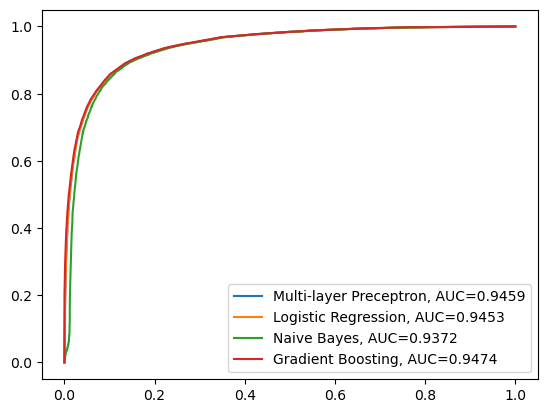

In [36]:
plt.plot(fpr4,tpr4,label="Multi-layer Preceptron, AUC="+str(auc4))
plt.plot(fpr1,tpr1,label="Logistic Regression, AUC="+str(auc1))
plt.plot(fpr2,tpr2,label="Naive Bayes, AUC="+str(auc2))
plt.plot(fpr3,tpr3,label="Gradient Boosting, AUC="+str(auc3))
plt.legend()
plt.show()


In [37]:
accuracies_train

[96.79080573462686, 95.65676199458282, 96.99668182942189, 96.80086951021042]

In [38]:
accuracies_test

[96.79080573462686, 95.65676199458282, 96.99668182942189, 96.80086951021042]

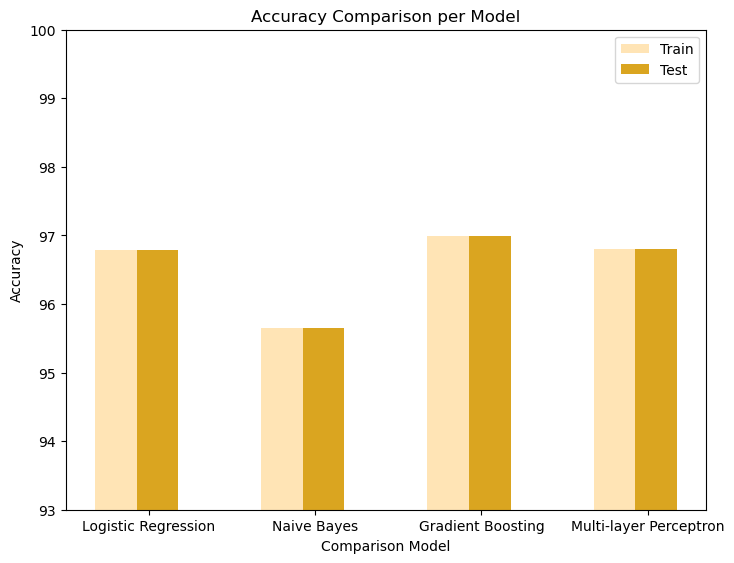

In [39]:
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,1,1,1])
ax.bar(X+0.0, accuracies_train, color='moccasin', width= 0.25)
ax.bar(X+0.25, accuracies_test, color='goldenrod', width=0.25)
ax.set_title('Accuracy Comparison per Model')
ax.set_xlabel("Comparison Model")
ax.set_ylabel("Accuracy")
ax.set_xticks(X + 0.2, ('Logistic Regression', 'Naive Bayes', 'Gradient Boosting', 'Multi-layer Perceptron'))
ax.set_ylim(93,100)
ax.legend(labels=['Train', 'Test'])
plt.show()

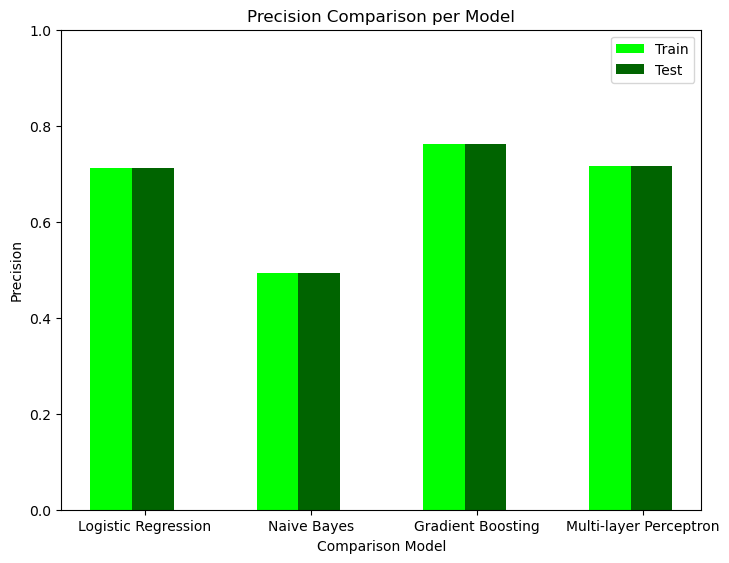

In [44]:
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,1,1,1])
ax.bar(X+0.0, precision_train, color='lime', width= 0.25)
ax.bar(X+0.25, precision_test, color='darkgreen', width=0.25)
ax.set_title('Precision Comparison per Model')
ax.set_xlabel("Comparison Model")
ax.set_ylabel("Precision")
ax.set_xticks(X + 0.2, ('Logistic Regression', 'Naive Bayes', 'Gradient Boosting', 'Multi-layer Perceptron'))
ax.set_ylim(0,1)
ax.legend(labels=['Train', 'Test'])
plt.show()

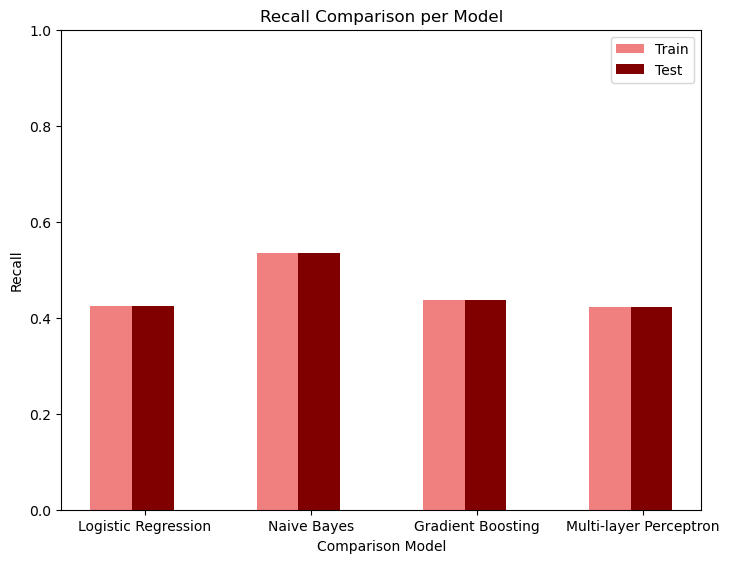

In [45]:
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,1,1,1])
ax.bar(X+0.0, recall_train, color='lightcoral', width= 0.25)
ax.bar(X+0.25, recall_test, color='maroon', width=0.25)
ax.set_title('Recall Comparison per Model')
ax.set_xlabel("Comparison Model")
ax.set_ylabel("Recall")
ax.set_xticks(X + 0.2, ('Logistic Regression', 'Naive Bayes', 'Gradient Boosting', 'Multi-layer Perceptron'))
ax.set_ylim(0,1)
ax.legend(labels=['Train', 'Test'])
plt.show()

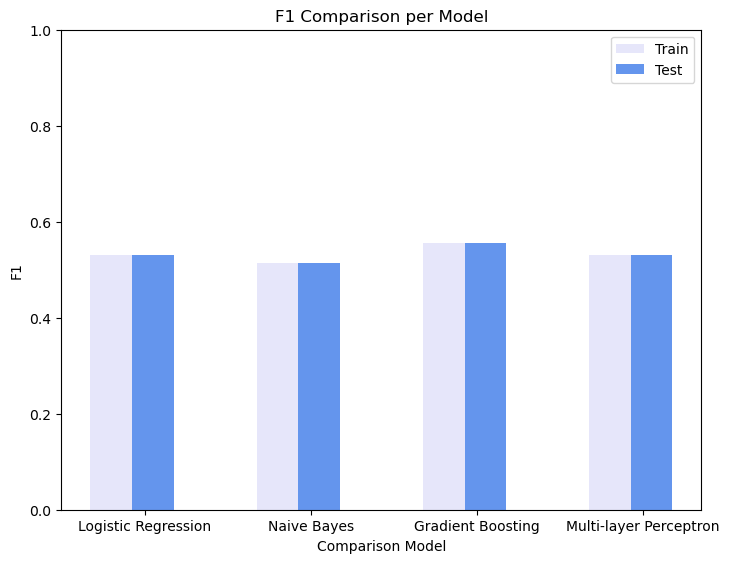

In [46]:
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,1,1,1])
ax.bar(X+0.0, f1_train, color='lavender', width= 0.25)
ax.bar(X+0.25, f1_test, color='cornflowerblue', width=0.25)
ax.set_title('F1 Comparison per Model')
ax.set_xlabel("Comparison Model")
ax.set_ylabel("F1")
ax.set_xticks(X + 0.2, ('Logistic Regression', 'Naive Bayes', 'Gradient Boosting', 'Multi-layer Perceptron'))
ax.set_ylim(0,1)
ax.legend(labels=['Train', 'Test'])
plt.show()

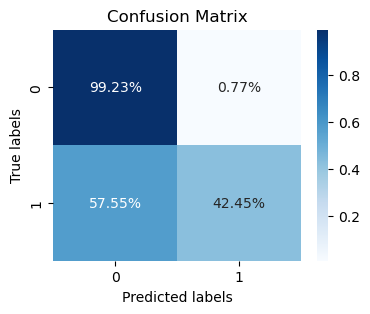

In [55]:
get_confmatrix(clr, X_test, y_test)

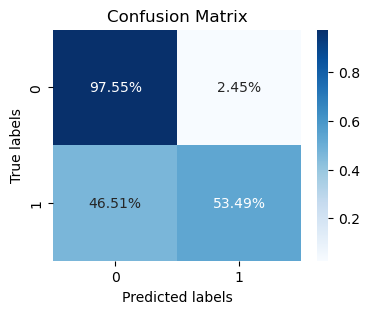

In [57]:
get_confmatrix(clnb, X_test, y_test)

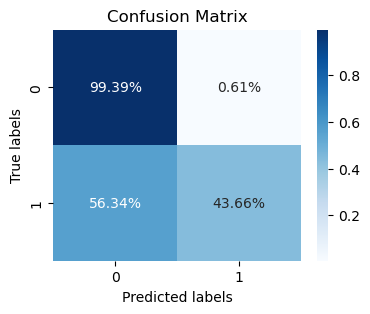

In [59]:
get_confmatrix(clfgb, X_test, y_test)

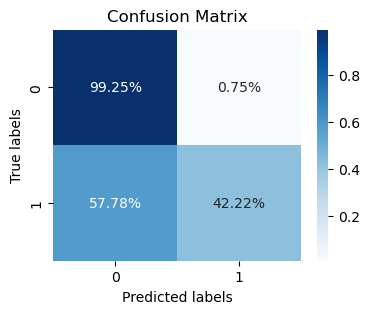

In [60]:
get_confmatrix(clmlp, X_test, y_test)

We can notice that the models provide of a high true negative rate close to $99.37\%$, but near $43.78\%$ to be the true positive rate. There are lots of False Negatives close to $56.22\%$. 

We can notice that what is mattering to us, is to provide of a good predictor that combines the scores from SpliceAI and Revel in order to predict Pathogenivity $Y=1$. It is important to understand through an arquitecture that is higly interpretable, to help understand the dependency between different lines of evidence of BP4 and PP3. Lower False Positive rate is something that the project is aiming, while preserving the true negative rate high. 

The next part of this project is to understand the interplay between the lines of evidence and its effect to predict pathogenicity.